In [1]:
import torch
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy
import numpy as np
from PIL import Image

data_train = datasets.MNIST(root="./dataset",train=True,download=True,transform=transforms.ToTensor())
data_test = datasets.MNIST(root="./dataset",train=False,download=True,transform=transforms.ToTensor())

In [2]:
len(data_train)

60000

In [3]:
len(data_test)

10000

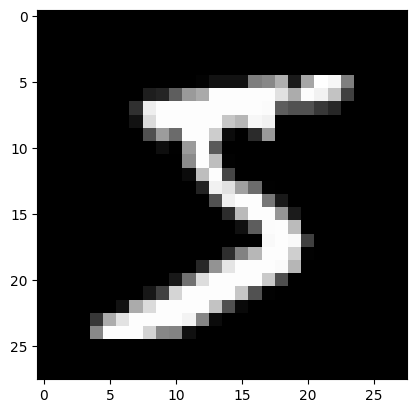

In [4]:
from matplotlib import pyplot as plt

image, label = data_train[0]

plt.imshow(image.squeeze().numpy(),cmap='gray')
plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F 

class UnkownNet(nn.Module):
    def __init__(self):
        super(UnkownNet,self).__init__()

        self.fc1 = nn.Linear(784,1)
        self.activation = nn.Sigmoid()

    def forward(self,input):

        f2 = self.fc1(input)

        output = self.activation(f2)

        return output
    
net = UnkownNet()


In [6]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.01)
loss_func = nn.BCELoss()

In [7]:
train_dataset = []

for x , y in data_train:

    if y % 2 != 0:
        y = np.array([1])
    else :
        y = np.array([0])

    x = x.squeeze().reshape(-1).numpy()

    train_dataset.append([x,y])

test_dataset = []

for x , y in data_test:

    if y % 2 != 0:
        y = np.array([1])
    else :
        y = np.array([0])

    x = x.squeeze().reshape(-1).numpy()

    test_dataset.append([x,y])

In [10]:
from torch.utils.data import dataset, DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=600,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=100,shuffle=True)

In [11]:
print(len(train_dataloader))
print(len(test_dataloader))

100
100


In [12]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [13]:
def resize_tensor(tensor):
    
    v_min, v_max = tensor.min(), tensor.max()
    
    new_min,new_max = 0,255
    
    v_p = (tensor - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
    
    return v_p
    

In [14]:
epochs = 2000

for epoch in range(epochs):

    loss_sum = 0.0
    test_sum = 0.0

    metric = BinaryAccuracy()

    for (train_features,train_labels),(test_features,test_labels) in zip(train_dataloader,test_dataloader) :

        epoch_y = net(train_features)
        loss = loss_func(epoch_y.to(torch.float32),train_labels.to(torch.float32))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0 :
            for m in net.modules():
                if isinstance(m,nn.Linear):
                    
                    img_tensor = m.weight.clone().detach()
                    img = resize_tensor(img_tensor.squeeze())
                    
                    img = img.reshape(28,28)
                    np_arr = np.array(img,dtype=np.uint8)
                                        
                    writer.add_image('weight_to_img',np_arr,epoch + 1,dataformats='WH')

        loss_sum += loss
        
        epoch_test_y = net(test_features)
        
        result_set = []
        
        for result in epoch_test_y:
            pre = result.item()
            
            if pre <= 0.5:
                result_set.append(np.array([0]))
            else:
                result_set.append(np.array([1]))
                
        result_set = np.array(result_set)
        result_set = torch.tensor(result_set)
        
        metric.update(result_set.squeeze(),test_labels.squeeze())
    acc = metric.compute()

    loss = loss_sum / len(train_dataloader)

    print('Epoch {:4d}/{} train_loss: {:.6f} acc: {:.6f}'.format(
        epoch+1, epochs, loss, acc
    ))

    if loss < 0.1 :
        break


Epoch    1/2000 train_loss: 0.572301 acc: 0.773500
Epoch    2/2000 train_loss: 0.464542 acc: 0.822300
Epoch    3/2000 train_loss: 0.421023 acc: 0.833300
Epoch    4/2000 train_loss: 0.396956 acc: 0.839300
Epoch    5/2000 train_loss: 0.381363 acc: 0.843900
Epoch    6/2000 train_loss: 0.370320 acc: 0.847900
Epoch    7/2000 train_loss: 0.362026 acc: 0.850800
Epoch    8/2000 train_loss: 0.355464 acc: 0.852800
Epoch    9/2000 train_loss: 0.350148 acc: 0.855900
Epoch   10/2000 train_loss: 0.345675 acc: 0.857900
Epoch   11/2000 train_loss: 0.341861 acc: 0.860500
Epoch   12/2000 train_loss: 0.338552 acc: 0.861400
Epoch   13/2000 train_loss: 0.335652 acc: 0.862500
Epoch   14/2000 train_loss: 0.333063 acc: 0.862900
Epoch   15/2000 train_loss: 0.330709 acc: 0.864200
Epoch   16/2000 train_loss: 0.328586 acc: 0.865700
Epoch   17/2000 train_loss: 0.326655 acc: 0.866500
Epoch   18/2000 train_loss: 0.324850 acc: 0.867800
Epoch   19/2000 train_loss: 0.323236 acc: 0.868100
Epoch   20/2000 train_loss: 0.3

In [15]:
test_result = []

test_y = []

final_metric = BinaryAccuracy()

for x ,y in test_dataset:
    pre = net(torch.tensor(x))
    
    if pre <= 0.5:
        test_result.append(np.array([0]))
    else:
        test_result.append(np.array([1]))
        
    test_y.append(y)
    
test_result = np.array(test_result)
test_result = torch.tensor(test_result)

test_origin = np.array(test_y)
test_origin = torch.tensor(test_y)

final_metric.update(test_result.squeeze(),test_origin.squeeze())
acc = final_metric.compute()

acc

AttributeError: 'Tensor' object has no attribute 'append'